In [102]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [103]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [104]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

In [105]:
series_1 = all_series["International airline passengers: monthly totals in thousands"]

In [106]:
series_2 = all_series["Daily total female births in California"]

# Нестационарный ряд

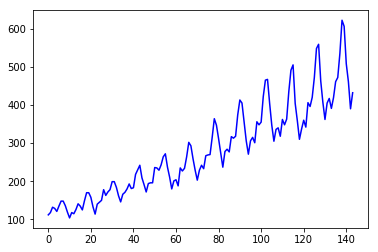

In [107]:
series_1.plot(color='blue')

In [108]:
def initial_trend(series, season_len):
    return sum([float(series[season_len] - series[0]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds=0):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()
        
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

def plot_dema(alpha, beta, ser):
    dema = double_ema(ser, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

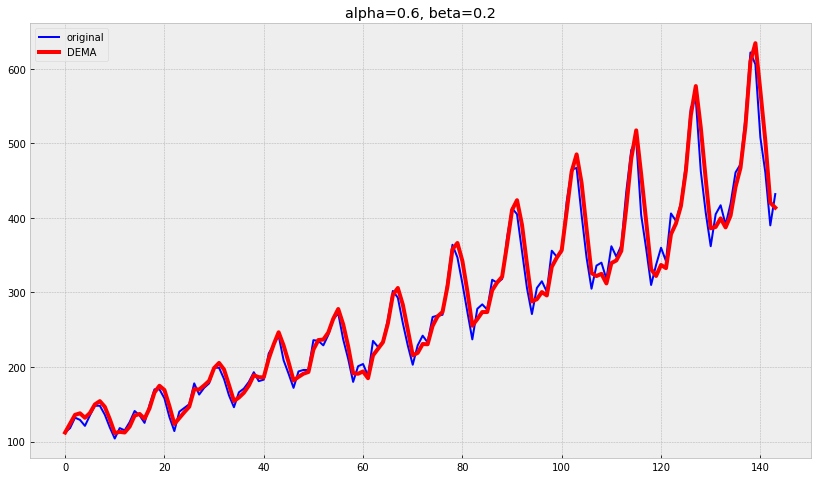

In [109]:
plot_dema(0.6, 0.2, series_1)

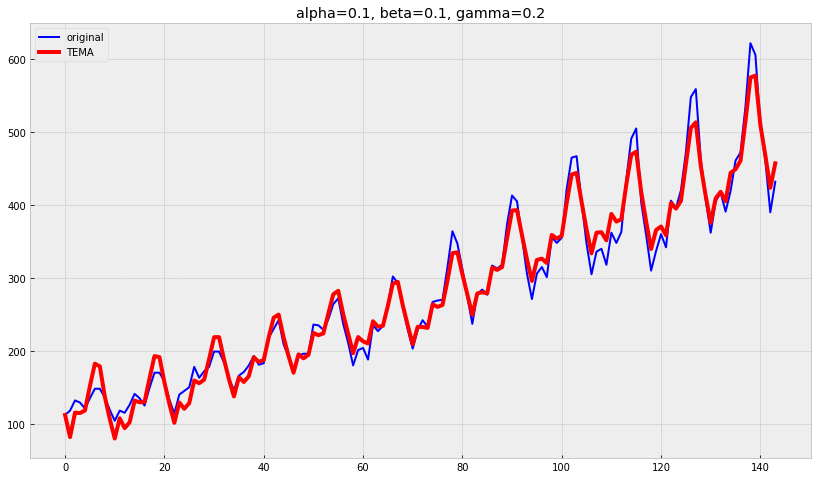

In [110]:
plot_tema(0.1, 0.1, 0.2, series_1, series_1)

In [111]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [112]:
train, val = series_1[:120], series_1[120:]

In [113]:
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [114]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [115]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 7.194013125912791e-06
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.31699084e-05, -5.57510344e-06,  2.29866031e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 356
      nit: 70
   status: 0
  success: True
        x: array([0.03948297, 0.27272121, 0.98040586])


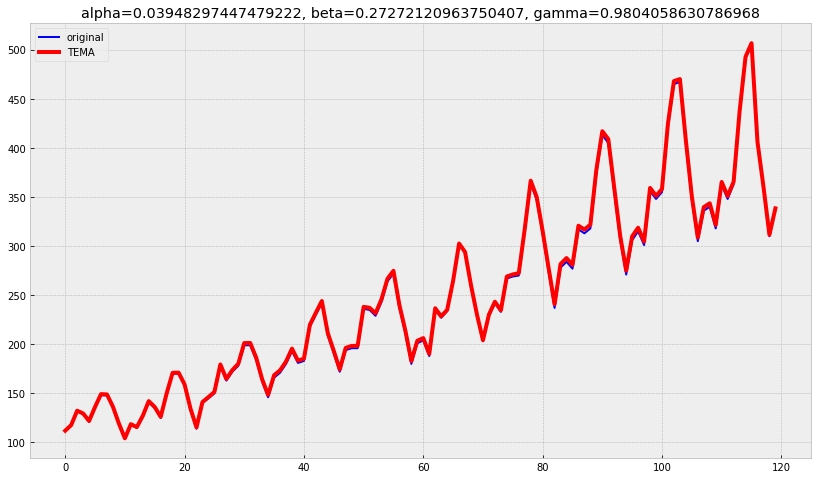

In [116]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=train, n_preds=0)

Метод Хольт-Винтерс описывает ряд лучше всего, так как в нем есть явновыреженная сезонность и тренд

# Стационарный ряд

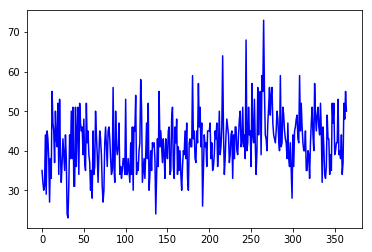

In [117]:
series_2.plot(color='blue')

In [118]:
series_2 = boxcox(series_2, 0)
series_2 = np.diff(series_2, 1)

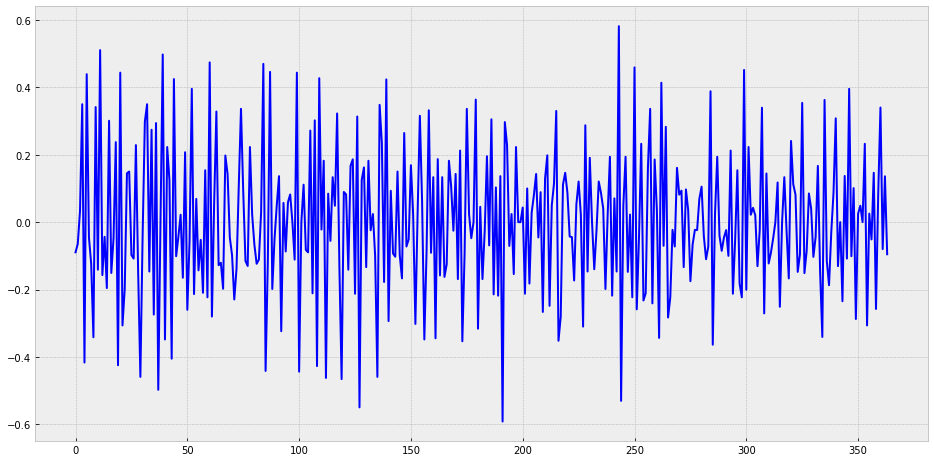

In [119]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    plt.plot(series_2, color='blue')

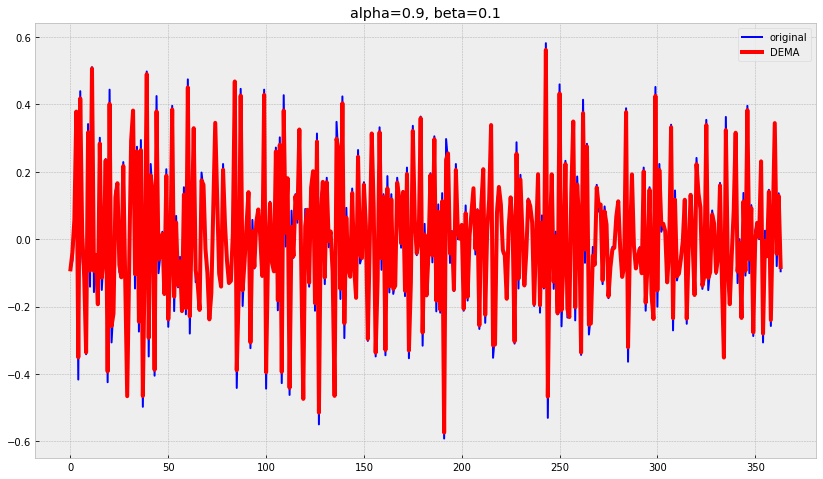

In [120]:
plot_dema(0.9, 0.1, series_2)

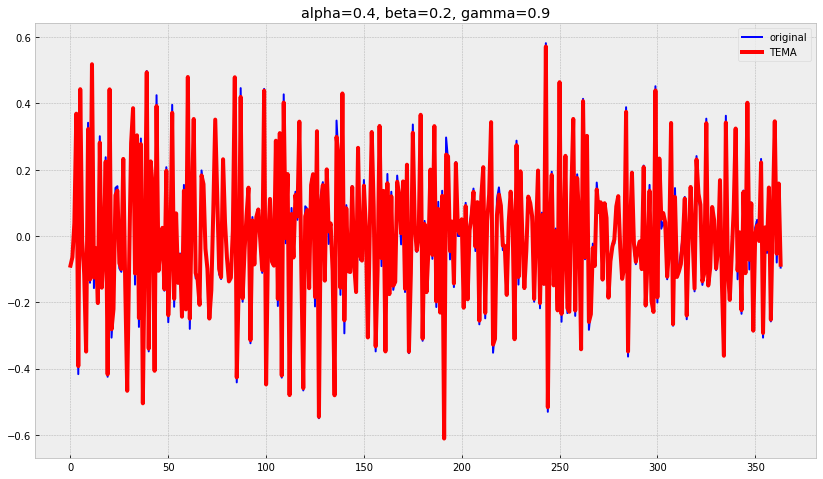

In [121]:
plot_tema(0.4, 0.2, 0.9, series_2, series_2)

In [122]:
train, val = series_2[:60], series_2[60:]

In [123]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [124]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.5870017919839695
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.54098956e-05,  2.55351296e-07,  1.15019105e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 224
      nit: 42
   status: 0
  success: True
        x: array([0.05128315, 0.4857449 , 0.83701763])


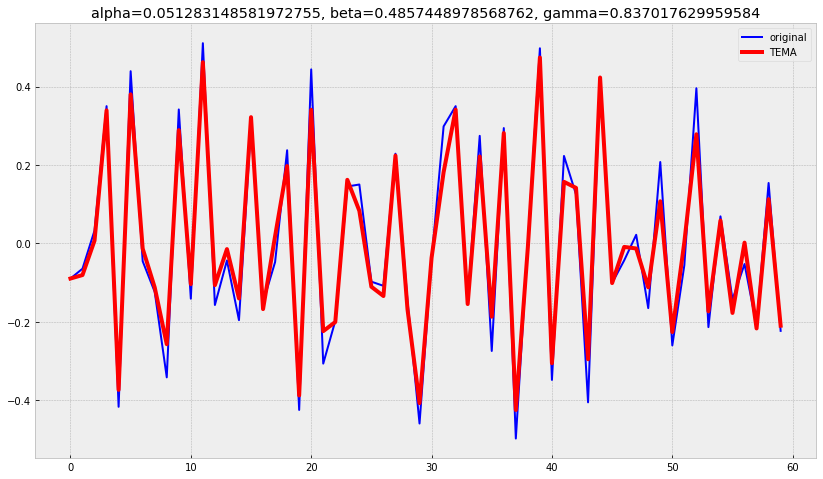

In [125]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=train, n_preds=0)

В данном случае метод Хольт-Винтерс дает достаточно хороший результат из чего можно стделать вывод, что ряд содержит сезонность